
⚠️ No model found in 80–90%. Picking closest ABOVE 0.90.

SELECTED MODEL (by CV)
CV Mean: 0.9313
CV Std : 0.0105
Params : {'k': 40, 'metric': 'euclidean', 'noise_enabled': True, 'noise_prob': 0.7, 'noise_std': 0.14, 'svd_components': 8, 'weights': 'uniform'}

FINAL TEST RESULTS
Test Accuracy: 0.915
Test LogLoss : 0.1955

✅ Saved JOBLIB: knn_best_80_90.joblib
✅ Saved PKL   : knn_best_80_90.pkl


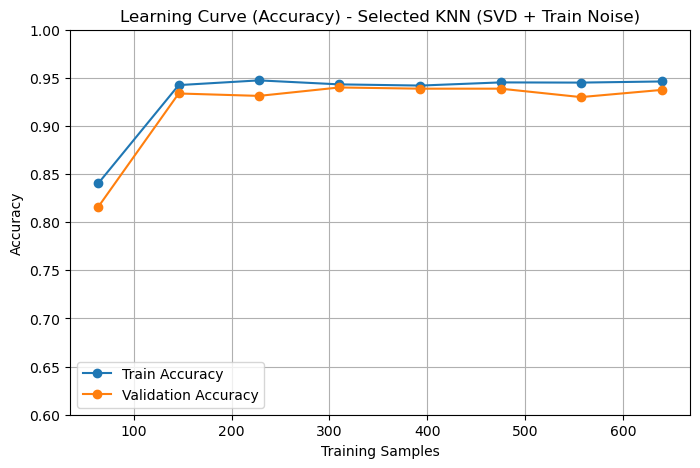

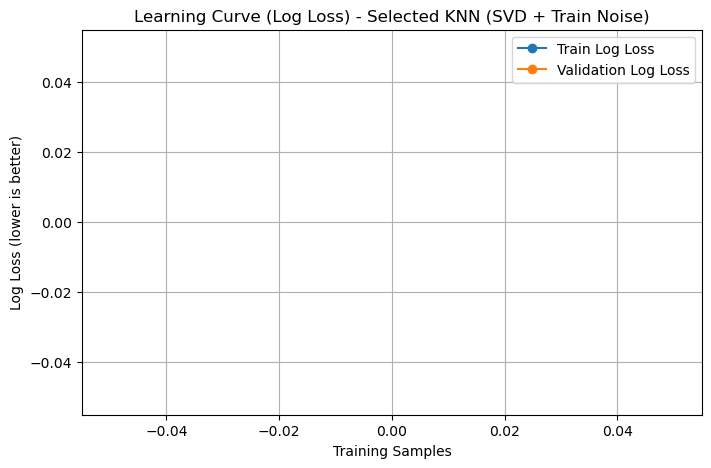

In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, learning_curve

import joblib, pickle

# =========================
# CONFIG
# =========================
DATA_PATH = r"KOA_Dataset_optionA.csv"
TARGET = "KOA"
RANDOM_STATE = 42
TEST_SIZE = 0.20

TARGET_MIN = 0.80
TARGET_MAX = 0.90

SAVE_JOBLIB = "knn_best_80_90.joblib"
SAVE_PKL    = "knn_best_80_90.pkl"


# =========================
# Train-only noise transformer (CV-safe)
# =========================
class TrainOnlyGaussianNoise(BaseEstimator, TransformerMixin):
    def __init__(self, std=0.06, prob=0.7, random_state=42, enabled=True):
        self.std = float(std)
        self.prob = float(prob)
        self.random_state = int(random_state)
        self.enabled = bool(enabled)

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        X = self._to_array(X)
        if (not self.enabled) or (self.std <= 0) or (self.prob <= 0):
            return X
        rng = np.random.default_rng(self.random_state)
        Xn = X.copy()
        mask = rng.random(Xn.shape[0]) < self.prob
        if mask.any():
            Xn[mask] = Xn[mask] + rng.normal(0.0, self.std, size=Xn[mask].shape)
        return Xn

    def transform(self, X):
        return self._to_array(X)

    @staticmethod
    def _to_array(X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        return np.asarray(X, dtype=np.float32)


# =========================
# LOAD DATA
# =========================
df = pd.read_csv(DATA_PATH)
df = df.drop(columns=["Timestamp", "Column 1", "Patient Identification Number"], errors="ignore")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

X = df.drop(columns=[TARGET], errors="ignore")
y = df[TARGET]

if y.dtype == "object":
    y = y.astype("category").cat.codes
else:
    y = y.astype(int)

# =========================
# COLUMN GROUPS
# =========================
num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# =========================
# PREPROCESS
# =========================
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# =========================
# SPLIT (TrainVal / Test)
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# =========================
# PARAM SEARCH SPACE (EDIT HERE)
# =========================
param_grid = {
    "svd_components": [4, 6, 8, 10, 12],      # lower -> lower acc
    "noise_enabled":  [True],
    "noise_std":      [0.00, 0.03, 0.06, 0.10, 0.14],
    "noise_prob":     [0.50, 0.70, 0.90],
    "k":              [40, 60, 80, 100, 120],
    "metric":         ["euclidean", "manhattan"],
    "weights":        ["uniform"]
}

# =========================
# Search + select best within 80–90
# =========================
results = []

for p in ParameterGrid(param_grid):
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("svd", TruncatedSVD(n_components=p["svd_components"], random_state=RANDOM_STATE)),
        ("train_noise", TrainOnlyGaussianNoise(
            std=p["noise_std"], prob=p["noise_prob"],
            random_state=RANDOM_STATE, enabled=p["noise_enabled"]
        )),
        ("model", KNeighborsClassifier(
            n_neighbors=p["k"], weights=p["weights"], metric=p["metric"]
        ))
    ])

    scores = cross_val_score(pipe, X_trainval, y_trainval, scoring="accuracy", cv=cv, n_jobs=-1)
    results.append({
        "params": p,
        "cv_mean": float(scores.mean()),
        "cv_std": float(scores.std())
    })

# Sort by CV mean
results_sorted = sorted(results, key=lambda d: d["cv_mean"], reverse=True)

# Filter those inside target range
in_range = [r for r in results_sorted if TARGET_MIN <= r["cv_mean"] <= TARGET_MAX]

if len(in_range) > 0:
    best = in_range[0]
    print("\n✅ Found model in 80–90% range!")
else:
    # If none in range: pick closest above 0.90 (or closest overall)
    above = [r for r in results_sorted if r["cv_mean"] > TARGET_MAX]
    if len(above) > 0:
        best = above[-1]  # closest above the threshold (lowest above 0.90)
        print("\n⚠️ No model found in 80–90%. Picking closest ABOVE 0.90.")
    else:
        best = results_sorted[-1]
        print("\n⚠️ No model found in 80–90%. Picking lowest overall model.")

print("\n=========================")
print("SELECTED MODEL (by CV)")
print("=========================")
print("CV Mean:", round(best["cv_mean"], 4))
print("CV Std :", round(best["cv_std"], 4))
print("Params :", best["params"])

# =========================
# Build final selected pipeline
# =========================
bp = best["params"]

final_pipe = Pipeline([
    ("preprocess", preprocess),
    ("svd", TruncatedSVD(n_components=bp["svd_components"], random_state=RANDOM_STATE)),
    ("train_noise", TrainOnlyGaussianNoise(
        std=bp["noise_std"], prob=bp["noise_prob"],
        random_state=RANDOM_STATE, enabled=bp["noise_enabled"]
    )),
    ("model", KNeighborsClassifier(
        n_neighbors=bp["k"], weights=bp["weights"], metric=bp["metric"]
    ))
])

# Fit on TrainVal, evaluate on Test
final_pipe.fit(X_trainval, y_trainval)

test_pred = final_pipe.predict(X_test)
test_prob = final_pipe.predict_proba(X_test)

test_acc = accuracy_score(y_test, test_pred)
test_ll  = log_loss(y_test, test_prob)

print("\n=========================")
print("FINAL TEST RESULTS")
print("=========================")
print("Test Accuracy:", round(test_acc, 4))
print("Test LogLoss :", round(test_ll, 4))

# =========================
# Save pipeline
# =========================
joblib.dump(final_pipe, SAVE_JOBLIB)
with open(SAVE_PKL, "wb") as f:
    pickle.dump(final_pipe, f)

print(f"\n✅ Saved JOBLIB: {SAVE_JOBLIB}")
print(f"✅ Saved PKL   : {SAVE_PKL}")

# =========================
# Learning Curves (Accuracy + LogLoss)
# =========================
train_sizes = np.linspace(0.1, 1.0, 8)

# Accuracy curve
sizes, tr_acc, va_acc = learning_curve(
    final_pipe, X_trainval, y_trainval,
    train_sizes=train_sizes,
    cv=cv, scoring="accuracy",
    n_jobs=-1, shuffle=True,
    random_state=RANDOM_STATE
)

plt.figure(figsize=(8,5))
plt.plot(sizes, tr_acc.mean(axis=1), marker="o", label="Train Accuracy")
plt.plot(sizes, va_acc.mean(axis=1), marker="o", label="Validation Accuracy")
plt.title("Learning Curve (Accuracy) - Selected KNN (SVD + Train Noise)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.ylim(0.60, 1.0)
plt.grid(True)
plt.legend()
plt.show()

# Log-loss curve
def neg_ll(estimator, Xb, yb):
    return -log_loss(yb, estimator.predict_proba(Xb))

ll_scorer = make_scorer(neg_ll, greater_is_better=True)

sizes, tr_ll, va_ll = learning_curve(
    final_pipe, X_trainval, y_trainval,
    train_sizes=train_sizes,
    cv=cv, scoring=ll_scorer,
    n_jobs=-1, shuffle=True,
    random_state=RANDOM_STATE
)

plt.figure(figsize=(8,5))
plt.plot(sizes, (-tr_ll).mean(axis=1), marker="o", label="Train Log Loss")
plt.plot(sizes, (-va_ll).mean(axis=1), marker="o", label="Validation Log Loss")
plt.title("Learning Curve (Log Loss) - Selected KNN (SVD + Train Noise)")
plt.xlabel("Training Samples")
plt.ylabel("Log Loss (lower is better)")
plt.grid(True)
plt.legend()
plt.show()
